In [1]:
import subprocess
# config
import common.init as init
from singleton_pattern.load_model import get_model
from  singleton_pattern.load_config import get_config
from singleton_pattern.load_dataset_reader import get_test_reader
from singleton_pattern.load_data_generator import create_tensor_data_generator
from common.cache import Cache
from common.cuda_info import get_device
from singleton_pattern.load_config import get_non_dnn_method_list
from common.cache import CacheType
from singleton_pattern.load_model import get_model
from loss.pearson import PearsonLoss
import math
import os
import numpy as np
import cv2
import concurrent.futures  
import traceback
import time
import threading
import pandas as pd
import matplotlib.pyplot as plt


config_name = 'PhysNet.yaml'
# config_name = 'POS.yaml'
# config_name = 'GREEN.yaml'
# config_name = 'PCA.yaml'
# motion = "static"
motion = "wark"


In [2]:
from common.face_detection import get_face


init.run(config_name,False)
config = get_config()
dataset_name = config['test']['dataset']['loader']

root_compress_output_path = f'./cache/COMPRESS_{dataset_name}'
root_out_path = f'./out/{dataset_name}'

os.makedirs(root_compress_output_path, exist_ok=True)
os.makedirs(root_out_path, exist_ok=True)


method = config.get('method')
config['test']['dataset']['force_clear_cache'] = True
ploss = PearsonLoss()
# 创建互斥锁
save_psnr_to_sheet_lock = threading.Lock()
save_ssim_to_sheet_lock = threading.Lock()
save_compression_ratio_to_sheet_lock = threading.Lock()
save_pearson_and_snr_lock = threading.Lock()
draw_lock = threading.Lock()
test_dataloader_lock = threading.Lock()
print_lock = threading.Lock()

def calculate(codec,suffix, mode,compression_strength):
    name = f'{codec}_{mode}_{str(compression_strength)}'
    # load test dataset
    test_reader = get_test_reader()
    video_paths,ppgs = test_reader.load_data(print_info = False)
    if codec != 'raw':
        codec_video_paths = [os.path.abspath(f'{root_compress_output_path}/{codec}_{motion}/{mode}_{str(compression_strength)}_{str(i)}.{suffix}') for i in  range(len(video_paths))]
    else:
        codec_video_paths = video_paths
    '''
        compress
    '''
    if codec != 'raw':
        # compress(video_paths,codec_video_paths,codec,mode, compression_strength)
        pass
    '''
        compression_ratios
    '''
    # calculate_compression_ratio(video_paths,codec_video_paths,name)
    '''
        video psnr, ssim
    '''
    # calculate_video_metrics(video_paths,codec_video_paths,codec,mode,compression_strength)

    '''
        pearson and snr
    '''
    calculate_pearson_and_snr(codec_video_paths,ppgs,name)



def compress(video_paths,output_video_paths,codec,mode, compression_strength):
    for i in range(len(video_paths)):
        video_path = video_paths[i]
        output_video_path = output_video_paths[i]
        bitrate = get_video_bitrate(video_path)
        dir = os.path.dirname(output_video_path)
        os.makedirs(dir, exist_ok=True)
        # yuv444p
        ffmpeg_command = ["ffmpeg","-i", video_path,"-gpu 0",]
        if codec != 'mjpeg':
            ffmpeg_command.append("-pix_fmt yuv444p")
        if mode == 'b':
            b = int(bitrate - math.sqrt(compression_strength/35) * (bitrate-100000))
            b = min(b,bitrate)
            maxrate = max(int((bitrate + b)/2),b+100000)
        if codec == 'libx265' or codec == 'libx264':
            ffmpeg_command.append("-refs 3")
            if codec == 'libx265' and compression_strength == 0:
                ffmpeg_command.append("-x265-params lossless=1",)
            elif  mode == 'crf' or mode == 'qp':
                ffmpeg_command.append(f"-{mode} {compression_strength}",)
            elif mode == 'b':
                ffmpeg_command.append(f"-b:v {b} -maxrate {maxrate}")
            ffmpeg_command.append("-tune psnr")
        elif codec == 'libx265_all_i' or codec == 'libx264_all_i':
            codec = 'libx265' if codec == 'libx265_all_i' else 'libx264'
            ffmpeg_command.append("-g 1")
            if codec == 'libx265' and compression_strength == 0:
                ffmpeg_command.append("-x265-params lossless=1",)
            elif  mode == 'crf' or mode == 'qp':
                ffmpeg_command.append(f"-{mode} {compression_strength}",)
            elif mode == 'b':
                ffmpeg_command.append(f"-b:v {b} -maxrate {maxrate}")
        elif codec == 'av1':
            if compression_strength == 0:
                codec = 'libaom-av1'
                ffmpeg_command.append(f"-crf {compression_strength} -aom-params lossless=1")
            elif  mode == 'crf' or mode == 'qp':
                codec = 'libsvtav1'
                ffmpeg_command.append("-svtav1-params tune=1:preset=3 -g 5")
                ffmpeg_command.append(f"-{mode} {compression_strength}")
            elif mode == 'b':
                codec = 'libsvtav1'
                # max 100000k 
                bitrate = 90000000
                b = int(bitrate - math.sqrt(compression_strength/35) * (bitrate-100000))
                ffmpeg_command.append(f"-svtav1-params rc=1:tune=1:preset=3 -b:v {b}  -g 3")
        elif codec == 'vp9_all_i':
            codec = 'libvpx-vp9'
            ffmpeg_command.append("-tune 0 -g 1")
            if compression_strength == 0:
                ffmpeg_command.append("-lossless 1")
            elif  mode == 'crf' or mode == 'qp':
                ffmpeg_command.append(f"-{mode} {compression_strength}")
            elif mode == 'b':
                ffmpeg_command.append(f"-b:v {b} -maxrate {maxrate}")
        elif codec == 'vp9':
            codec = 'libvpx-vp9'
            ffmpeg_command.append("-tune 0 -g 3")
            if compression_strength == 0:
                ffmpeg_command.append("-lossless 1")
            elif  mode == 'crf' or mode == 'qp':
                ffmpeg_command.append(f"-{mode} {compression_strength}")
            elif mode == 'b':
                ffmpeg_command.append(f"-b:v {b} -maxrate {maxrate}")
        elif codec == 'mjpeg':
            if mode == 'q':
                ffmpeg_command.append(f'-q:v {compression_strength}')
            elif mode == 'b':
                ffmpeg_command.append(f"-b:v {b} -maxrate {maxrate}")
        elif codec == 'prores_ks':
            ffmpeg_command.append(f'-profile:v {compression_strength}')
        else:
            raise Exception("不支持的编码")
        ffmpeg_command.append(f"-codec {codec} {output_video_path}")
        if os.path.exists(output_video_path):
            os.remove(output_video_path)
        # print(" ".join(ffmpeg_command))
        try:
            subprocess.run(" ".join(ffmpeg_command),check=True)
            pass
        except subprocess.CalledProcessError as e:
            print(e)

def calculate_compression_ratio(video_paths, codec_video_paths,sheet_name):
    compression_ratios = []
    video_bitrates = []
    for index in range(len(video_paths)):
        video_path = video_paths[index]
        codec_video_path = codec_video_paths[index]
        original_size = os.path.getsize(video_path)
        codec_size = os.path.getsize(codec_video_path)
        ratio = codec_size / original_size
        compression_ratios.append([ratio])
        video_bitrates.append([get_video_bitrate(codec_video_path)])
    compression_ratios = np.array(compression_ratios).T
    video_bitrates = np.array(video_bitrates).T
    # 保存
    with save_compression_ratio_to_sheet_lock:
        save_to_sheet(f'compression_ratios',sheet_name,compression_ratios)
        save_to_sheet(f'video_bitrates',sheet_name,video_bitrates)

    
def calculate_video_metrics(video_paths,codec_video_paths,codec,mode,intensity):
    videos_psnrs = []
    videos_ssims = []
    for index in range(len(video_paths)):
        video_path = video_paths[index]
        codec_video_path = codec_video_paths[index]
        # break
        psnrs = []
        ssims = []
        cap1 = cv2.VideoCapture(video_path)
        cap2 = cv2.VideoCapture(codec_video_path)
        index = 0
        sleep_time = 0
        face = None
        while True:
            ret1, frame_1 = cap1.read()
            ret2, frame_2 = cap2.read()
            if not ret1 or not ret2:
                if sleep_time < 120 and index == 0:
                    sleep_time += 1
                    time.sleep(1)
                    continue
                break
            if index >= 1 and index < 201:
                save_frame_diff(frame_1,frame_2,f'{root_out_path}/img/diff/{codec}_{motion}/{mode}__{str(intensity)}_{str(index)}.png')
            face = get_face(frame_1,face)
            if face == None:
                continue
            t,b,l,r = face.top(),face.bottom(),face.left(),face.right()
            frame_1_face = frame_1[t:b, l:r]
            frame_2_face = frame_2[t:b, l:r]
            psnr = PSNR(frame_1_face,frame_2_face)
            psnrs.append(psnr)
            # ssim = SSIM(frame_1, frame_2)
            # ssims.append(ssim)
            index += 1
        videos_psnrs.append(psnrs)
        videos_ssims.append(ssims)
        cap1.release()
        cap2.release()
        if sleep_time >= 120:
            raise Exception(f'无法加载视频：{codec_video_paths[index]}')
    videos_psnrs = np.array(videos_psnrs).T
    videos_ssims = np.array(videos_ssims).T
    # 保存
    sheet_name = f'{codec}_{mode}_{str(intensity)}'
    with save_psnr_to_sheet_lock:
        save_to_sheet('psnr',sheet_name,videos_psnrs)
    with save_ssim_to_sheet_lock:
        save_to_sheet('ssim',sheet_name,videos_ssims)
    pass

def calculate_pearson_and_snr(codec_video_paths,ppgs,name):
    test_data_generator = create_tensor_data_generator(CacheType.TEST_SYNC)
    test_dataloader = test_data_generator.get_tensor_dataloader((codec_video_paths,ppgs),print_info = False)
    non_dnn_method_list = get_non_dnn_method_list()
    is_need_train = config['method'] not in non_dnn_method_list
    model = get_model()
    if is_need_train:
        cache_model = Cache(CacheType.MODEL).read_model()
        model.load_state_dict(cache_model.state_dict())
    model.eval()
    gpu_device = get_device()
    model.to(gpu_device)

    pearsons = []
    snrs = []
    b_num = 0
    with test_dataloader_lock:
        for batch_X, batch_y in test_dataloader:
            batch_X = batch_X.to(gpu_device)
            batch_y = batch_y.cpu()
            outputs = model.forward(batch_X).cpu()
            p = ploss.forward(batch_y,outputs)
            s = RMSE(batch_y,outputs)
            pearsons.append(p.detach().cpu().numpy())
            snrs.append(s)
            bvp_image_path = f'{root_out_path}/img/bvp_{motion}/{config["method"]}/{name}'
            os.makedirs(bvp_image_path, exist_ok=True)
            with draw_lock:
                draw(f'{bvp_image_path}/{str(b_num)}.png',batch_y,outputs)
            b_num += 1
    datas = {
        'pearson':np.array(pearsons),
        'rmse':np.array(snrs)
    }
    with save_pearson_and_snr_lock:
        save_pearson_and_snr(name,datas)


def save_frame_diff(frame_1,frame_2,file_path):
    subtracted_frame = cv2.absdiff(frame_1, frame_2)
    gray_frame = cv2.cvtColor(subtracted_frame,cv2.COLOR_BGR2GRAY)
    gamma = 0.3
    gamma_corrected_frame = np.power(gray_frame / 255.0, gamma) * 255.0
    gamma_corrected_frame = np.uint8(gamma_corrected_frame)
    directory = os.path.dirname(file_path)
    os.makedirs(directory, exist_ok=True)
    cv2.imwrite(file_path,cv2.cvtColor(gamma_corrected_frame,cv2.COLOR_GRAY2BGR))

def save_to_sheet(name,sheet_name,datas):
    file_path = f'{root_out_path}/{name}_{motion}.xlsx'
    if not os.path.exists(file_path):
        pd.DataFrame().to_excel(file_path)
    with pd.ExcelWriter(file_path, mode='a', engine='openpyxl') as writer:
        try:
            writer.book.remove(writer.book[sheet_name])
        except:
            pass
        df = pd.DataFrame(datas)
        df.to_excel(writer, index=False, sheet_name=sheet_name,header=[f'video_{str(i+1)}' for i in range(datas.shape[1])])



def save_pearson_and_snr(sheet_name,datas):
    file_path = f'{root_out_path}/{config["method"]}_pearson_and_snr_{motion}.xlsx'
    if not os.path.exists(file_path):
        pd.DataFrame().to_excel(file_path)
    with pd.ExcelWriter(file_path, mode='a', engine='openpyxl') as writer:
        try:
            writer.book.remove(writer.book[sheet_name])
        except:
            pass
        df = pd.DataFrame(datas)
        df.to_excel(writer, index=False, sheet_name=sheet_name,header=True)

def draw(file_path,y_1,y_2):
    y_1 = y_1.detach().cpu().numpy().flatten()
    y_2 = y_2.detach().cpu().numpy().flatten()
    plt.clf()
    plt.plot(y_1)
    plt.plot(y_2)
    plt.savefig(file_path)
    # plt.show()

def get_video_bitrate(filename):
    ffprobe_command = ["ffprobe", "-i", filename, "-show_entries", "format=bit_rate", "-v", "quiet", "-of", "csv=p=0"]
    try:
        ffprobe_output = subprocess.check_output(ffprobe_command).decode("utf-8").strip()
    except Exception as e:
        return 0
    return int(ffprobe_output)

def PSNR(frame_1,frame_2):

    f_pow = np.power(frame_1 - frame_2,2)
    average_per_channel = np.mean(f_pow, axis=-1)
    mse = average_per_channel/(frame_1.shape[0] * frame_1.shape[1])
    if (np.sum(mse)/3) == 0:
        return np.inf
    return 10 * np.log10(np.power(255,2) / (np.sum(mse)/3))

def SSIM(frame_1, frame_2, K1=0.01, K2=0.03, L=255):
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    mean_1 = np.mean(frame_1, axis=(0, 1))
    mean_2 = np.mean(frame_2, axis=(0, 1))
    var_1 = np.var(frame_1, axis=(0, 1))
    var_2 = np.var(frame_2, axis=(0, 1))
    covariance = np.cov(np.ravel(frame_1), np.ravel(frame_2))
    numerator = (2 * mean_1 * mean_2 + C1) * (2 * covariance + C2)
    denominator = (mean_1 ** 2 + mean_2 ** 2 + C1) * (var_1 + var_2 + C2)
    return np.mean(numerator / denominator)

def SNR(y_1,y_2):
    y_1 = y_1.detach().cpu().numpy().flatten()
    y_2 = y_2.detach().cpu().numpy().flatten()
    # 计算信号和噪声的功率
    signal_power = np.mean(y_1 ** 2)
    noise_power = np.mean((y_1 - y_2) ** 2)
    # 检查噪声功率是否为0
    if noise_power == 0:
        return float('inf')  # 返回正无穷，表示信号远远大于噪声
    # 计算信噪比
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

def RMSE(y_1,y_2):
    y_1 = y_1.detach().cpu().numpy().flatten()
    y_2 = y_2.detach().cpu().numpy().flatten()
    return np.sqrt(((y_1 - y_2) ** 2).mean())

def task_wrap(*args, **kwargs):
    try:
        calculate(*args, **kwargs)
        pass
    except Exception  as e:
        with print_lock:
            print(e)
            traceback.print_exc()
    with print_lock:
        print(*args, str(kwargs))
    # print(str(threading.get_ident()))

In [3]:
def run(codecs,suffixs,compression_strengths,modes):
    for codec,suffix in zip(codecs,suffixs):
        tasks = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            for mode in modes:
                for compression_strength in compression_strengths:
                    param = {'codec':codec,'suffix':suffix,'mode':mode,'compression_strength':compression_strength}
                    tasks.append(executor.submit(task_wrap, **param))
            for future in concurrent.futures.as_completed(tasks):
                pass

cache path:cache\TEST_SYNC\ce8ca24bb180a1afdece0518af3c7c3ff4ae8bb9da280c84bdac3e88384c7a7f
cache path:cache\TEST_SYNC\a32d30bfea86f3ab0c864d9f7e2c2b21e3605643ff3f0251f18fc18c1b1b62aa
cache path:cache\TEST_SYNC\b01ac9bcff8e2970e2a65bb4d2d77c122173d4b1114656b8c9bc9b7d87af6a74
cache path:cache\TEST_SYNC\ca4befd70dfeca15f885a21d8561b62bb324beadc75f5906bc25e6d589add84c
cache path:cache\TEST_SYNC\6228d40638e6b5ffb74578d13b99fba1dff3b9e3ee174fd3ac7f2422a453d257
cache path:cache\TEST_SYNC\2041e6069f503a6e77700d644c1ec7aa22c02f43949b0ae14363963578f9e026
cache path:cache\TEST_SYNC\21e5875503da05167ecb140870077e664acc52f56b307f0a0936a67ef1211aba
cache path:cache\TEST_SYNC\24337d48a3866627af5b07000e175180f96a69619c6984541c4fa6a7ee4ebb5f
cache path:cache\MODEL\
cache path:cache\MODEL\
cache path:cache\MODEL\
cache path:cache\MODEL\
cache path:cache\MODEL\
cache path:cache\MODEL\
cache path:cache\MODEL\
cache path:cache\MODEL\
{'codec': 'libx264_all_i', 'suffix': 'avi', 'mode': 'qp', 'compression_s

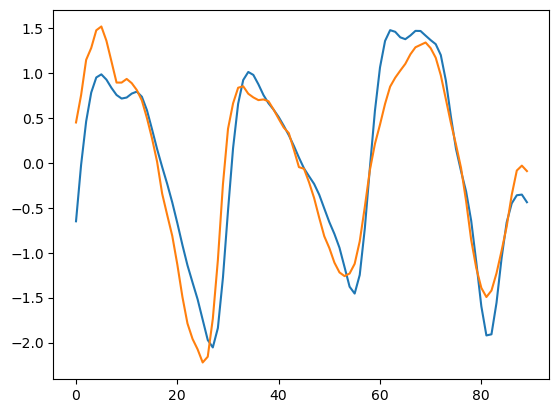

In [4]:
codecs = ['libx264_all_i','libx265_all_i']
suffixs = ['avi','mp4']
compression_strengths = [1,4,8,10,14,20,24,30]
modes = ['qp']
run(codecs,suffixs,compression_strengths,modes)

cache path:cache\TEST_SYNC\3672826df15d1ad7ed20dbf5aee224f4644c5d007178919c5d8840a7b8672052
cache path:cache\TEST_SYNC\2701be142c4a761328561e74917bee3fd960565ecabbe4495d6d3c7d1343a848
cache path:cache\TEST_SYNC\7717ed30a73892217a5931e7cca15c49207f338e0ae42748c3a983a3f9574f8b
cache path:cache\TEST_SYNC\eda9ad8f20826c36dcdb941ba9aed19ebce20ec50a913bc8829a2ac2e8760048
cache path:cache\TEST_SYNC\26949d544209216119e8cd3c64d258074e4c29e0e1bf34b2e13069a51d4baa7f
cache path:cache\MODEL\cache path:cache\MODEL\

cache path:cache\MODEL\
cache path:cache\MODEL\
cache path:cache\MODEL\
{'codec': 'prores_ks', 'suffix': 'mov', 'mode': 'q', 'compression_strength': 1}
{'codec': 'prores_ks', 'suffix': 'mov', 'mode': 'q', 'compression_strength': 0}
{'codec': 'prores_ks', 'suffix': 'mov', 'mode': 'q', 'compression_strength': 2}
{'codec': 'prores_ks', 'suffix': 'mov', 'mode': 'q', 'compression_strength': 4}
{'codec': 'prores_ks', 'suffix': 'mov', 'mode': 'q', 'compression_strength': 3}


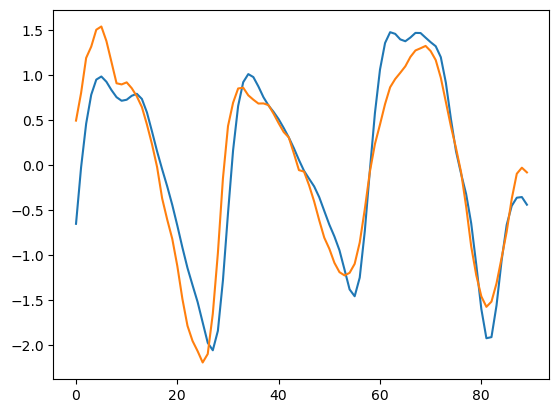

In [5]:
codecs = ['prores_ks']
suffixs = ['mov']
compression_strengths = range(0, 5)
modes = ['q']
run(codecs,suffixs,compression_strengths,modes)

cache path:cache\TEST_SYNC\fc817f70abe2958368b4bd092f240dc5d18dc9f4bfd3a1709a4e4d06224d6435cache path:cache\TEST_SYNC\5fa19855bf0aeb8868553da67f44276a7e2f1179b9bb41d57425514f7eb13885

cache path:cache\TEST_SYNC\2b0b8e5bf8506cae430c0d0715907f60830d81f6eccf18075130bba0d0d42000
cache path:cache\TEST_SYNC\747ded55b9a36c6edef62330c6f4108775e0f614f396cc667d160ea4a3821c4b
cache path:cache\TEST_SYNC\b562a0ac9e0dd88fd926d5c4040aabc7c56d191be47b495a46d842524e19ebdb
cache path:cache\TEST_SYNC\b79010b113566367d00484b82c18b4d22c9cf38b635f6ed4eb9adeb07768148d
cache path:cache\TEST_SYNC\55871ff3aab57658edb6936335f395154732f83b5719dcb17fa444c63e9e7ba3
cache path:cache\TEST_SYNC\14fb007cc6170651176fc100ebfe5537ce530a50ce782cad0ec57909038abba8
cache path:cache\TEST_SYNC\073915a07912190e09780b98d2f3d2190c3aa9450a715fc25f5eef1c8cdbd31f
cache path:cache\TEST_SYNC\ce5b397c9eb15324a80c42e2e3d8bccbc38235b122958cce0582e0ff5f7be7fa
cache path:cache\TEST_SYNC\2b275c4d2daba38c9f5c43b5b604c4cad48b7642db6482fe7d99a

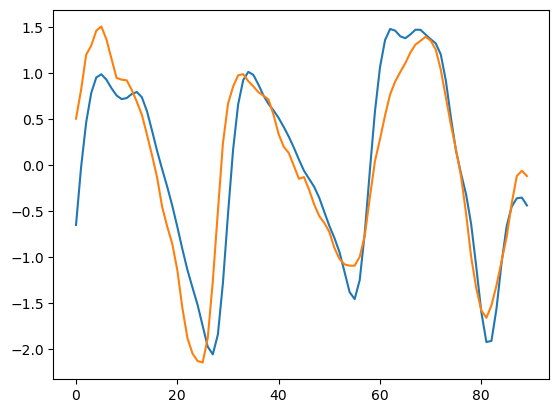

In [6]:
codecs = ['mjpeg']
suffixs = ['avi']
compression_strengths = range(2, 32)
modes = ['q']
run(codecs,suffixs,compression_strengths,modes)

cache path:E:\cache\TEST_SYNC\9280123c84f471bfb3c818c30038806b42aac07fafbbba6cd19b2dd5c6b5bd42cache path:E:\cache\TEST_SYNC\b1b2a95753a4a02b38ea8b614b9265a67c9a112bac54fd09eb1435984fd94132
cache path:E:\cache\TEST_SYNC\b8fef106a6fb65ae9682bd1b46e62f9231e1899072e9b5e91f43281b4eb21f53
cache path:E:\cache\TEST_SYNC\f3dac65109dd8f85fc467f9a8d84baa868d9294acd83e653449e0924354f7bc7
cache path:E:\cache\TEST_SYNC\aba40560bb0e320fe251e70caa053198a6e4f4c6b1809fa4060d505a4efb38b4

cache path:E:\cache\TEST_SYNC\403ef4ebf90c5015e42e774b734b0f868496a9453d1bfdcaf7903d7d218962b3
cache path:E:\cache\TEST_SYNC\d4f4710b6f2ef9ca2eed90ab9412ff94a9a6f9219f1a3d575b8b711227145bf6
cache path:E:\cache\TEST_SYNC\08dcd2d6c63f3399a2e52e6fcfbf371e9ee8d96c3d5c32377709d9562f918735
cache path:E:\cache\TEST_SYNC\01e0eeeee455af8f6ce43468fa66b4f8b94700791ce275b2b72fed8de0514c37
cache path:E:\cache\TEST_SYNC\3563be73c119b3ee7140bc9b034a4722c6477f8fc69a50ca0765c24c8b7b24df
cache path:E:\cache\TEST_SYNC\65396ed73c388a26ac6f

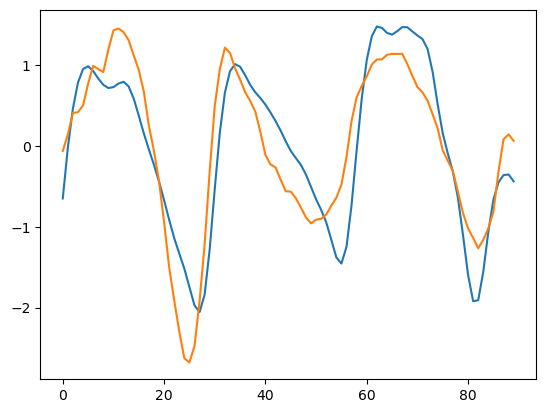

In [4]:
codecs = ['libx264','libx265','av1']
suffixs = ['avi','mp4','mkv']
compression_strengths = range(1, 36)
modes = ['crf','qp','b']
run(codecs,suffixs,compression_strengths,modes)

cache path:cache\TEST_SYNC\8a18cad6f4deea5eb821bec649acd3d994491810dd75ebb19d3a64892eebaf2b
cache path:cache\TEST_SYNC\86d1eeb2f4c4e2c26a77640d753f62f83833e48ed846e23886af30645b9915fa
cache path:cache\TEST_SYNC\9f1f5d600e18468ab7addfd1c264d86110556cf5340c90b4a47da207fecf47ac
cache path:cache\TEST_SYNC\6b8b41d082a55bf6128de5caa152aa561a0899bfc99deb6e0efa8c9487b0d8aa
cache path:cache\TEST_SYNC\0d43792ee04923b64ac3a2d44e33aa4749a063f3073cd0a4e0b6f334a72e03f4
cache path:cache\TEST_SYNC\9787a6e9b67b1ca012377d440fd65b5bbec9c924b971a079c9db8fc6bc9dc5ac
cache path:cache\TEST_SYNC\9b1692d6dbf1d0ab69cccb0e0680f10813bb55cccc22005275cd1f96e7862532
cache path:cache\TEST_SYNC\a9f560f1ebdd5ac9ea05d94f2a8d09ea4718426289d010129e584eda495263ad
cache path:cache\TEST_SYNC\9f2d560a298984d8d32a32a8c854ee0ab342ef01cab0a62b9f82736526268040
cache path:cache\TEST_SYNC\f53311c6aaea1cd4325ab7e7eac89ab71af48dda3b12ddf79acda47a53923238
cache path:cache\TEST_SYNC\61e057324594ce1002e3df4ac4af4151e147f5ac00e2f05f3d2d7

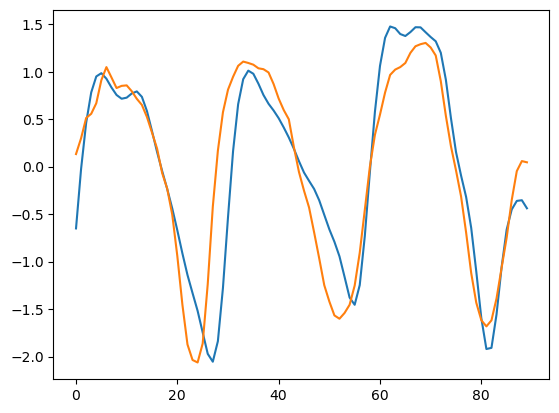

In [4]:
codecs = ['vp9']
suffixs = ['mkv']
compression_strengths = range(1, 36)
modes = ['crf','b']
run(codecs,suffixs,compression_strengths,modes)

In [9]:
# shutil.rmtree(root_compress_output_path,ignore_errors=True)